<h1>Urban Sound Classification with Random Forests and Support Vector Machines</h1>


We face the problem of urban sound classification extracting time and frequency domain features together with MFCC and Chroma representation of audio signals. Then, we compute statistics on this features, obtaining a tabular dataset which we will use to train random forests and support vector machines, validating our models with 10-fold cross-validation. Everything is done on the [UrbanSound8K](https://urbansounddataset.weebly.com/urbansound8k.html) dataset.

First, we set all the seed variable to allow reproducibility.

In [ ]:
seed = 0
import os
os.environ["PYTHONHASHSEED"] = "0"
import random
random.seed(seed)
import numpy as np
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)

Then, we define some features that will help us in extracting the features and computing statistics.

In [ ]:
from scipy.stats import skew, kurtosis
def compute_statistics(feature_array:np.ndarray):
    statistics = []
    statistics.append(np.min(feature_array))
    statistics.append(np.max(feature_array))
    statistics.append(np.mean(feature_array))
    statistics.append(np.median(feature_array))
    statistics.append(np.std(feature_array))
    return np.array(statistics)


def amplitude_envelope(signal:np.ndarray, frame_length=2048, hop_length=512):
    return np.array([max(signal[i:i+frame_length]) for i in range(0, signal.shape[0], hop_length)])


def extract_feature(feature_name:str, signal:np.ndarray, sr=22050, n_fft=2048, hop_length=512, n_mfcc=13, n_mels=128, n_chroma=12):
    statistics = []
    
    if feature_name == "amplitude_envelope":
        features = amplitude_envelope(signal, frame_length=n_fft, hop_length=hop_length)
        statistics = compute_statistics(features)
    
    elif feature_name == "mfcc":
        mfcc = getattr(librosa.feature, feature_name)(signal, sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
        delta_1 = librosa.feature.delta(mfcc, mode="constant", order=1)
        delta_2 = librosa.feature.delta(mfcc, mode="constant", order=2) 
        for coefficient in mfcc:
            statistics.append(compute_statistics(coefficient))
        for coefficient in delta_1:
            statistics.append(compute_statistics(coefficient))
        for coefficient in delta_2:
            statistics.append(compute_statistics(coefficient))
            
    elif feature_name == "melspectrogram":
        melspectrogram = getattr(librosa.feature, feature_name)(signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)    
        for coefficient in melspectrogram:
            statistics.append(compute_statistics(coefficient))
            
    elif feature_name == "chroma_stft":
        chroma_stft = getattr(librosa.feature, feature_name)(signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_chroma=12)
        for coefficient in chroma_stft:
            statistics.append(compute_statistics(coefficient))
    
    elif feature_name == "tonnetz":
        tonnetz = getattr(librosa.feature, feature_name)(signal, sr=sr)
        for coefficient in tonnetz:
            statistics.append(compute_statistics(coefficient))
    
    elif feature_name == "rms" or feature_name == "zero_crossing_rate":
        features = getattr(librosa.feature, feature_name)(signal, frame_length=n_fft, hop_length=hop_length)
        statistics = compute_statistics(features[0])
        
    else:
        features = getattr(librosa.feature, feature_name)(signal, n_fft=n_fft, hop_length=hop_length)
        statistics = compute_statistics(features[0])
        
    return statistics

Once the data are downloaded, we can have a look at the `metadata` table: we will use it to extract the fold and the label of the samples.

In [ ]:
import pandas as pd
metadata = pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")
metadata

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


Class mapping

In [ ]:
classes = {i:"" for i in range(10)}

for row in metadata[["classID", "class"]].iterrows():
    class_id, class_name = row[1]
    if classes[class_id] == "":
        classes[class_id] = class_name

for k, v in classes.items():
    print(f" {k}  ==>  {v}")

 0  ==>  air_conditioner
 1  ==>  car_horn
 2  ==>  children_playing
 3  ==>  dog_bark
 4  ==>  drilling
 5  ==>  engine_idling
 6  ==>  gun_shot
 7  ==>  jackhammer
 8  ==>  siren
 9  ==>  street_music


There is a slight imbalance in the dataset. But, except car horn and gun shot, the other classes are well represented. 

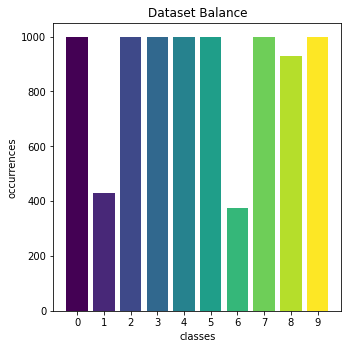

car_horn = 429
gun_shot = 374
siren = 929


In [ ]:
unique, counts = np.unique(metadata["classID"], return_counts=True)

!mkdir plots

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("classes")
ax.set_ylabel("occurrences")
ax.set_xticks(range(10))
cmap=plt.cm.get_cmap('viridis', 10)
plt.bar(unique, counts, color=cmap.colors)
plt.title("Dataset Balance")
fig.savefig("plots/class_balance.png", bbox_inches='tight')
plt.show()

for class_id, count in list(zip(unique, counts)):
    if count < 1000:
        print(f"{classes[class_id]} = {count}")

Once we set `sampling rate=22050` and `max_duration=4` we can load the data with Librosa and zero-pad all the shorter signals. Then, we extract the folds and labels from the metadata and guild our signal/fold/label dataset. We will use it to extract features and build the final dataset.

In [ ]:
import librosa

sr = 22050
max_duration = 4

signals, folds, labels, file_names = [], [], [], []
for fold in range(1, 11):
    directory = "UrbanSound8K/audio/" + "fold" + str(fold)
    for file in os.listdir(directory):
        if "wav" not in file:
            continue
        signal = librosa.load(directory+"/"+file)[0][:sr*4]
        signal = np.pad(signal, (0, sr*max_duration - signal.shape[0]))
        signals.append(signal)
        folds.append(metadata.loc[metadata.slice_file_name==file, "fold"].values[0])
        labels.append(metadata.loc[metadata.slice_file_name==file, "classID"].values[0])
        file_names.append(metadata.loc[metadata.slice_file_name==file, "slice_file_name"].values[0])

dataset = pd.DataFrame(columns=["file_name", "fold", "label"])
dataset["signal"] = signals
dataset["fold"] = folds
dataset["label"] = labels
dataset["file_name"] = file_names

In [ ]:
dataset.drop(["signal"], axis=1).to_csv("dataset.csv", index=False)
dataset = dataset.drop(["file_name"], axis=1)

Now we choose the features that will be extract and set all the parameters, in particular: `n_fft=1024`, `hop_length=256`, `n_mfcc=13`, `n_chroma=12`, `n_tonnetz=6`. This we lead to vectors of length `⌈22050×4÷256⌉=345`. We compute `min`, `max`, `mean`, `median` and `standard deviation` on these vectors and obtain what we call *statistical features*.

In [ ]:
features_names = ["spectral_centroid", "spectral_rolloff", "spectral_bandwidth", "spectral_flatness", "zero_crossing_rate", "rms", "amplitude_envelope", "mfcc", "chroma_stft", "tonnetz"]           

sr = 22050
n_fft = 1024
hop_length = 256

n_mfcc = 13
n_chroma = 12
n_tonnetz = 6

In [ ]:
features = []
for j in range(n_mfcc*3):
    for f in range(5):
        features.append("mfcc_"+str(j)+"_"+str(f))
for j in range(n_chroma):
    for f in range(5):
        features.append("chroma_stft_"+str(j)+"_"+str(f))
for j in range(n_tonnetz):
    for f in range(5):
        features.append("tonnetz_"+str(j)+"_"+str(f))

for name in features_names:
    if "mfcc" not in name or "chroma" not in name or "tonnetz" not in name:
        for f in range(5):
            features.append(name+"_"+str(f))

features_dict = {feature:[] for feature in features}

In [ ]:
for i, signal in enumerate(dataset["signal"]):

    for name in features_names:
        feature_statistics = extract_feature(name, signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc, n_mels=n_mels)
        
        if "mfcc" in name or "chroma_stft" in name or "tonnetz" in name:
            for j in range(len(feature_statistics)):
                for f, elem in enumerate(feature_statistics[j]):
                    features_dict[name+"_"+str(j)+"_"+str(f)].append(elem)
        else:
            for f, elem in enumerate(feature_statistics):
                features_dict[name+"_"+str(f)].append(elem)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


Now we have our final dataset: as it can be seen, for each computed feature we obtained 5 values; for MFCC and Chroma, we obtain 5 values for each coefficient, since we consider each coefficient as a single feature and compute statistics on it.

In [ ]:
empties = [key for key, value in features_dict.items() if len(value)==0]
for key in empties:
    features_dict.pop(key) 

dataset = pd.concat([dataset, pd.DataFrame.from_dict(features_dict)], axis=1)
dataset

,fold,label,signal,mfcc_0_0,mfcc_0_1,mfcc_0_2,mfcc_0_3,mfcc_0_4,mfcc_1_0,mfcc_1_1,mfcc_1_2,mfcc_1_3,mfcc_1_4,mfcc_2_0,mfcc_2_1,mfcc_2_2,mfcc_2_3,mfcc_2_4,mfcc_3_0,mfcc_3_1,mfcc_3_2,mfcc_3_3,mfcc_3_4,mfcc_4_0,mfcc_4_1,mfcc_4_2,mfcc_4_3,mfcc_4_4,mfcc_5_0,mfcc_5_1,mfcc_5_2,mfcc_5_3,mfcc_5_4,mfcc_6_0,mfcc_6_1,mfcc_6_2,mfcc_6_3,mfcc_6_4,mfcc_7_0,mfcc_7_1,...,tonnetz_5_0,tonnetz_5_1,tonnetz_5_2,tonnetz_5_3,tonnetz_5_4,spectral_centroid_0,spectral_centroid_1,spectral_centroid_2,spectral_centroid_3,spectral_centroid_4,spectral_rolloff_0,spectral_rolloff_1,spectral_rolloff_2,spectral_rolloff_3,spectral_rolloff_4,spectral_bandwidth_0,spectral_bandwidth_1,spectral_bandwidth_2,spectral_bandwidth_3,spectral_bandwidth_4,spectral_flatness_0,spectral_flatness_1,spectral_flatness_2,spectral_flatness_3,spectral_flatness_4,zero_crossing_rate_0,zero_crossing_rate_1,zero_crossing_rate_2,zero_crossing_rate_3,zero_crossing_rate_4,rms_0,rms_1,rms_2,rms_3,rms_4,amplitude_envelope_0,amplitude_envelope_1,amplitude_envelope_2,amplitude_envelope_3,amplitude_envelope_4
0,1,3,"[-0.00011783496, -0.00017157062, -0.0001774939...",-579.094116,-204.384842,-471.809662,-530.155762,112.265900,10.687771,200.387939,85.474144,65.602890,66.484596,-54.233265,66.832710,18.614037,19.387186,23.704519,-86.710800,34.988827,-11.209041,9.336641,34.886898,-55.592300,22.643238,-4.956341,0.383295,21.044746,-29.526123,20.597351,2.922532,5.032752,10.528765,-64.007004,16.235302,-13.037572,-1.369219,25.830923,-51.019100,14.614677,...,-0.067656,0.100208,0.003282,0.005535,0.030026,596.392804,3479.384621,1243.702722,1119.496840,493.241865,624.462891,8591.748047,2386.690302,1765.722656,1809.237396,862.840820,3637.021642,1897.378072,1856.217900,644.558409,0.000032,0.051006,0.003410,0.001495,0.005570,0.010742,0.104492,0.040970,0.041992,0.014661,0.000327,0.390949,0.058665,0.001873,0.096901,0.000926,0.805337,0.147096,0.006717,0.219839
1,1,7,"[-0.018801296, 0.0015772205, 0.035678826, 0.00...",-261.732880,-196.381592,-228.323914,-227.860535,14.406817,51.359070,101.176117,75.414413,75.944160,9.561481,-27.437323,12.776640,-6.393806,-6.328491,6.712902,9.991987,49.591034,26.926981,27.078117,5.399047,-29.655437,-1.068169,-15.698678,-15.695137,5.652170,-0.842451,28.771305,11.940084,11.791668,5.295284,-17.263420,10.682062,-2.382299,-2.023194,5.295827,-3.787384,28.882318,...,-0.037741,0.074422,0.024147,0.022493,0.025063,2214.442980,3460.683333,2902.181181,2896.221746,267.055339,4737.304688,6933.691406,5888.738111,5835.498047,402.619058,2324.837469,2899.693576,2618.730164,2608.738218,126.509564,0.027062,0.169836,0.084378,0.082571,0.028530,0.106445,0.231445,0.173650,0.172852,0.019783,0.024211,0.035843,0.030111,0.030085,0.002257,0.065964,0.130882,0.093763,0.092199,0.012137
2,1,3,"[0.23950581, 0.35340017, 0.29654667, 0.2917560...",-577.357788,-185.429413,-487.338409,-564.464050,118.441620,9.644294,191.505341,62.871704,26.019135,56.343468,-55.438171,58.209064,10.948213,16.929951,18.579462,-88.692039,31.923054,-0.708363,14.052917,30.065571,-53.224514,28.285633,3.321015,10.393401,16.502680,-24.787098,17.591564,3.277839,6.139019,10.095020,-72.874496,15.962517,-6.958458,3.472213,22.956451,-46.703377,14.682550,...,-0.098202,0.114042,-0.014128,-0.014156,0.027652,632.618541,3647.921274,1431.046604,1331.048521,492.992269,839.794922,7795.019531,2747.761549,2411.718750,1421.931867,959.838062,3396.611150,2085.616547,2169.330685,450.584594,0.000055,0.095412,0.008570,0.002992,0.015285,0.004883,0.158203,0.048619,0.043945,0.029724,0.000338,0.403369,0.035541,0.000890,0.078655,0.000799,0.777372,0.090207,0.002331,0.186250
3,1,3,"[-0.005227178, -0.0069225472, -0.0060946643, -...",-499.050964,-342.356110,-465.564362,-471.294952,22.222963,54.248436,137.519928,84.599579,81.431961,14.740129,-52.292503,42.130749,19.973169,23.248236,12.536654,-15.037521,54.544899,22.869286,23.707937,11.166036,-20.077812,31.185139,6.272762,6.699629,8.231943,-13.598323,39.953213,11.187878,11.362781,7.228487,-20.603703,21.476721,-1.139560,-0.786383,7

After scaling the data, we apply dimensionality reduction for visualization.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

scaled_dataset = pd.DataFrame(StandardScaler().fit_transform(dataset.drop(["signal","fold", "label"], axis=1)), columns=[col for col in dataset.columns if "signal" not in col and "fold" not in col and "label" not in col])

pca_dataset = PCA(n_components=2, random_state=seed).fit_transform(scaled_dataset)
tsne_dataset = TSNE(n_components=2, learning_rate="auto", init="pca", random_state=seed).fit_transform(PCA(n_components=50, random_state=seed).fit_transform(scaled_dataset))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [ ]:
!mkdir plots

def dim_reduction_plot(first_dimension:np.array, second_dimension:np.array, labels:np.array, title:str, save=None):
    fig = plt.figure(figsize=(8, 8))
    plt.title(title)
    cmap=plt.cm.get_cmap('jet', len(np.unique(labels)))
    scatter = plt.scatter(first_dimension, second_dimension, alpha=0.7, marker=".", c=labels, cmap=cmap)
    plt.legend(handles=scatter.legend_elements()[0])
    if save:
        plt.savefig("plots/"+title+".png")
    plt.show()

mkdir: cannot create directory ‘plots’: File exists


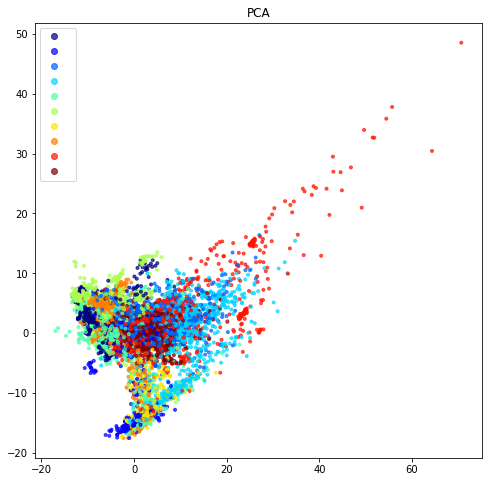

In [ ]:
dim_reduction_plot(pca_dataset[:, 0], pca_dataset[:, 1], dataset["label"], title="PCA", save=True)

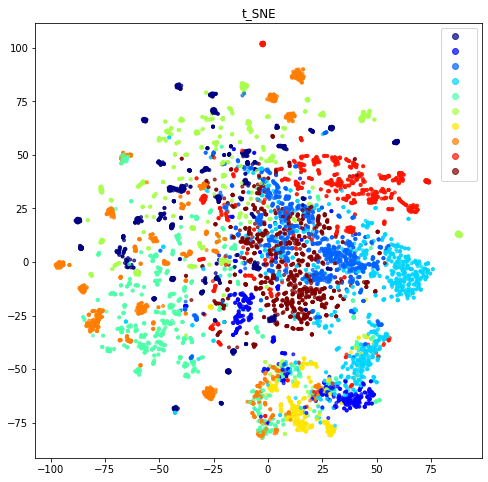

In [ ]:
dim_reduction_plot(tsne_dataset[:, 0], tsne_dataset[:, 1], dataset["label"], title="t_SNE", save=True)

Now we move to clustering: we apply KMeans for different values of K and on different set of features to check if the elbow heuristic will give us an optimal number of cluster.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
K=range(2, 13)
def kmeans(X, K=range(2, 16)):
    clusters, silhouette, inertia = [], [], []
    for k in K:
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=seed, copy_x=False, algorithm='auto').fit(X)
        Y_kmeans = kmeans.predict(X)
        clusters.append(Y_kmeans)
        silhouette.append(silhouette_score(X, Y_kmeans, metric='euclidean', sample_size=None, random_state=seed))
        inertia.append(kmeans.inertia_)
    return (clusters, silhouette, inertia)

In [ ]:
mfcc_y, mfcc_silhouette, mfcc_inertia = kmeans(scaled_dataset[[col for col in scaled_dataset.columns if "mfcc" in col]], K)
chroma_y, chroma_silhouette, chroma_inertia = kmeans(scaled_dataset[[col for col in scaled_dataset.columns if "chroma" in col or "tonnetz" in col]], K)
freq_y, freq_silhouette, freq_inertia = kmeans(scaled_dataset[[col for col in scaled_dataset.columns if "spectral" in col]], K)
time_y, time_silhouette, time_inertia = kmeans(scaled_dataset[[col for col in scaled_dataset.columns if "zero" in col or "rms" in col or "amplitude" in col]], K)
overall_Y, overall_silhouette, overall_inertia = kmeans(scaled_dataset, K)

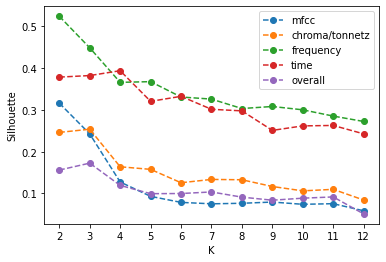

In [ ]:
plt.figure()
plt.xlabel("K")
plt.xticks(K)
plt.ylabel("Silhouette")
plt.plot(K, mfcc_silhouette, label="mfcc", linestyle='--', marker='o')
plt.plot(K, chroma_silhouette, label="chroma/tonnetz", linestyle='--', marker='o')
plt.plot(K, freq_silhouette, label="frequency", linestyle='--', marker='o')
plt.plot(K, time_silhouette, label="time", linestyle='--', marker='o')
plt.plot(K, overall_silhouette, label="overall", linestyle='--', marker='o')
plt.legend()
plt.savefig("plots/silhouette.png")
plt.show()

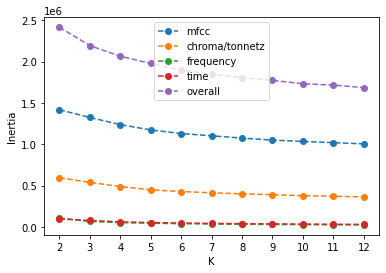

In [ ]:
plt.figure()
plt.xlabel("K")
plt.xticks(K)
plt.ylabel("Inertia")
plt.plot(K, mfcc_inertia, label="mfcc", linestyle='--', marker='o')
plt.plot(K, chroma_inertia, label="chroma/tonnetz", linestyle='--', marker='o')
plt.plot(K, freq_inertia, label="frequency", linestyle='--', marker='o')
plt.plot(K, time_inertia, label="time", linestyle='--', marker='o')
plt.plot(K, overall_inertia, label="overall", linestyle='--', marker='o')
plt.legend()
plt.savefig("plots/elbow.png")
plt.show()

We also use the t-SNE reduced dataset with the labels obtained with KMeans for K=10 on all the features.

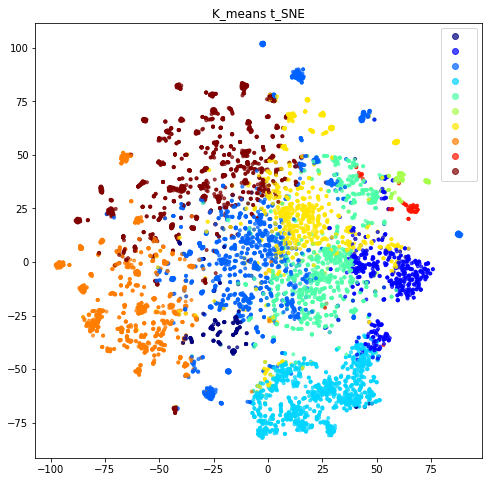

In [ ]:
dim_reduction_plot(tsne_dataset[:, 0], tsne_dataset[:, 1], overall_Y[8], title="K_means t_SNE", save=True)

Now we move to training. We will use random forests and support vector machines, validating our models with 10-fold cross-validation, both on random splits and on the predefined splits given by the authors.

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=True, title="Confusion matrix", cmap=plt.cm.Blues, path=None):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  
    if path:
        plt.savefig("plots/"+str(path).lower()+"_confusion_matrix.png")

    plt.show()

0-th fold:

RF  Train accuracy:         0.9994909646220412
RF  Test  accuracy:         0.8901601830663616



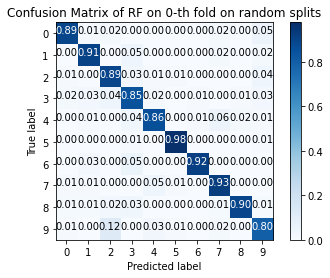

SVM Train accuracy:         0.9960549758208196
SVM Test  accuracy:         0.9427917620137299



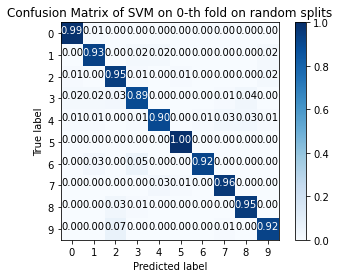

------------------------------------------------
1-th fold:

RF  Train accuracy:         0.9993637057775515
RF  Test  accuracy:         0.9118993135011442



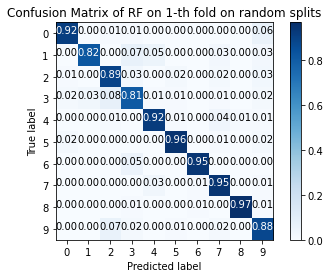

SVM Train accuracy:         0.995036905064902
SVM Test  accuracy:         0.9496567505720824



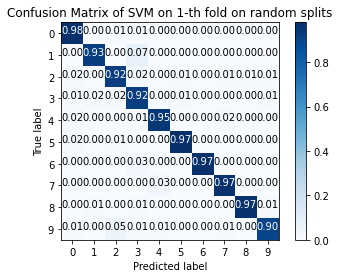

------------------------------------------------
2-th fold:

RF  Train accuracy:         0.9993637867413157
RF  Test  accuracy:         0.8957617411225659



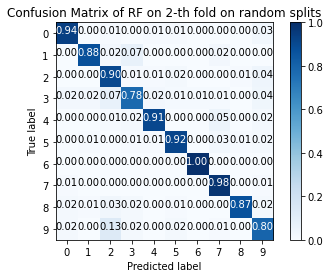

SVM Train accuracy:         0.9947830512787886
SVM Test  accuracy:         0.9438717067583047



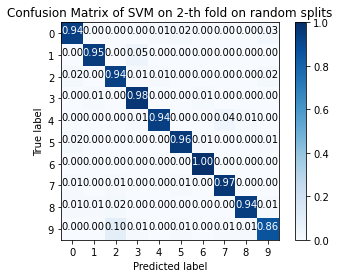

------------------------------------------------
3-th fold:

RF  Train accuracy:         0.9998727573482631
RF  Test  accuracy:         0.9026345933562429



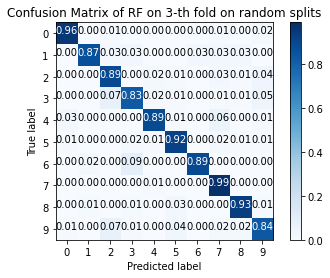

SVM Train accuracy:         0.9949102939305255
SVM Test  accuracy:         0.9404352806414662



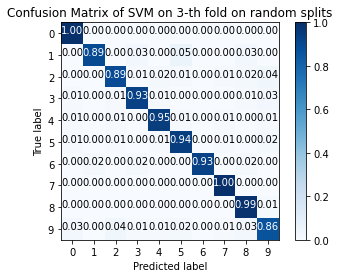

------------------------------------------------
4-th fold:

RF  Train accuracy:         0.9994910293930526
RF  Test  accuracy:         0.8991981672394044



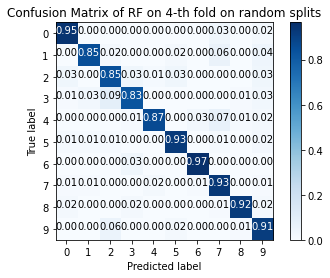

SVM Train accuracy:         0.9946558086270518
SVM Test  accuracy:         0.9530355097365406



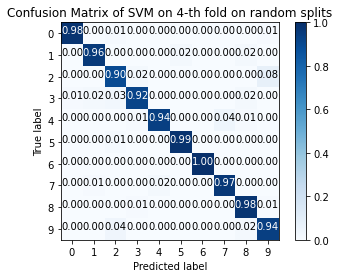

------------------------------------------------
5-th fold:

RF  Train accuracy:         0.9993637867413157
RF  Test  accuracy:         0.8900343642611683



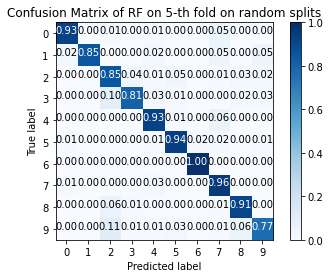

SVM Train accuracy:         0.9955465071892098
SVM Test  accuracy:         0.9347079037800687



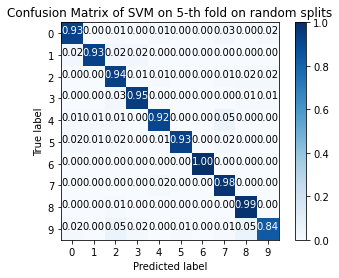

------------------------------------------------
6-th fold:

RF  Train accuracy:         0.9994910293930526
RF  Test  accuracy:         0.9129438717067583



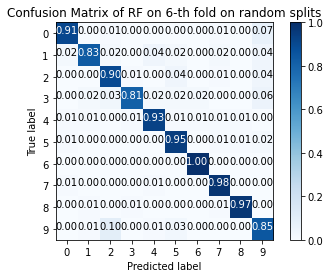

SVM Train accuracy:         0.9949102939305255
SVM Test  accuracy:         0.9507445589919816



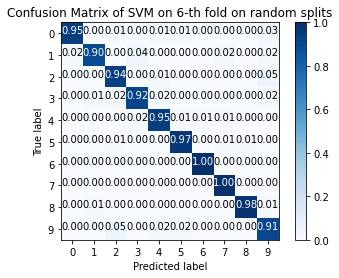

------------------------------------------------
7-th fold:

RF  Train accuracy:         0.9993637867413157
RF  Test  accuracy:         0.8843069873997709



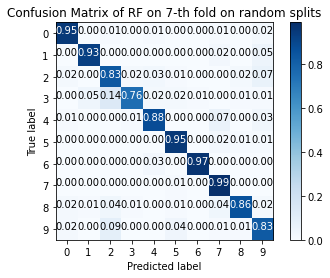

SVM Train accuracy:         0.9952920218857361
SVM Test  accuracy:         0.9473081328751431



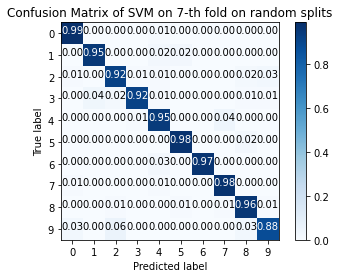

------------------------------------------------
8-th fold:

RF  Train accuracy:         0.9993637867413157
RF  Test  accuracy:         0.9117983963344788



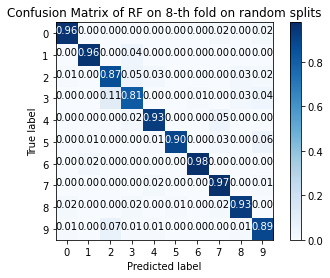

SVM Train accuracy:         0.9947830512787886
SVM Test  accuracy:         0.9484536082474226



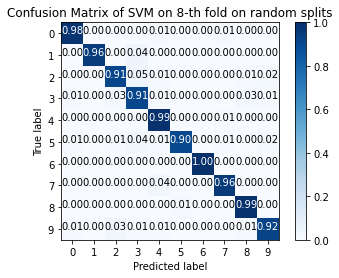

------------------------------------------------
9-th fold:

RF  Train accuracy:         0.9997455146965263
RF  Test  accuracy:         0.8694158075601375



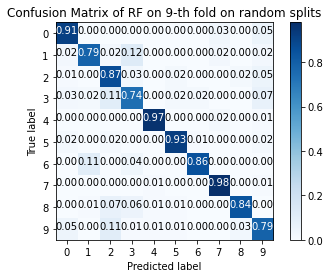

SVM Train accuracy:         0.9947830512787886
SVM Test  accuracy:         0.9392898052691867



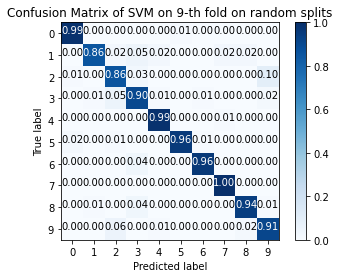

------------------------------------------------




RF  Avg training accuracy :   0.9995
RF  Avg test accuracy     :   0.8968


SVM Avg training accuracy :   0.9951
SVM Avg test accuracy     :   0.945


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

kfold = KFold(10, shuffle=True, random_state=seed)
indices = []

rf_scores, svm_scores = [], []

for k, (train_indices, test_indices) in enumerate(kfold.split(dataset)):

    indices.append((train_indices, test_indices))

    to_drop = ["signal", "label", "fold"]

    X_train = dataset.drop(to_drop, axis=1).iloc[train_indices]
    X_test = dataset.drop(to_drop, axis=1).iloc[test_indices]

    Y_train = dataset["label"][train_indices]
    Y_test = dataset["label"][test_indices]

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    rf = RandomForestClassifier(n_estimators=1000, max_features="auto", max_depth=15, bootstrap=True, criterion="gini", class_weight="balanced", random_state=seed).fit(X_train, Y_train)
    svm = SVC(C=7, kernel="rbf", gamma="scale", class_weight="balanced", break_ties=True, random_state=seed).fit(X_train, Y_train)

    rf_train_scores = rf.score(X_train, Y_train)
    rf_test_scores = rf.score(X_test, Y_test)
    rf_scores.append((rf_train_scores, rf_test_scores))
    rf_cm = confusion_matrix(Y_test, rf.predict(X_test))

    svm_train_scores = svm.score(X_train, Y_train)
    svm_test_scores = svm.score(X_test, Y_test)
    svm_scores.append((svm_train_scores, svm_test_scores))
    svm_cm = confusion_matrix(Y_test, svm.predict(X_test))

    print(f"{k}-th fold:\n")

    print(f"RF  Train accuracy:         {rf_train_scores}")
    print(f"RF  Test  accuracy:         {rf_test_scores}\n")

    plot_confusion_matrix(rf_cm, np.unique(Y_test), title="Confusion Matrix of RF on "+str(k)+"-th fold on random splits", path="cm_rf_"+str(k)+"_random")

    print(f"SVM Train accuracy:         {svm_train_scores}")
    print(f"SVM Test  accuracy:         {svm_test_scores}\n")

    plot_confusion_matrix(svm_cm, np.unique(Y_test), title="Confusion Matrix of SVM on "+str(k)+"-th fold on random splits", path="cm_svm_"+str(k)+"_random")

    print("------------------------------------------------")

print("\n\n\n")
print(f"RF  Avg training accuracy :   {round(np.mean([s[0] for s in rf_scores]), 4)}")
print(f"RF  Avg test accuracy     :   {round(np.mean([s[1] for s in rf_scores]), 4)}")
print("\n")
print(f"SVM Avg training accuracy :   {round(np.mean([s[0] for s in svm_scores]), 4)}")
print(f"SVM Avg test accuracy     :   {round(np.mean([s[1] for s in svm_scores]), 4)}")

In [ ]:
splits = {i:{"train":indices[i][0].tolist(), "test":indices[i][1].tolist()} for i in range(10)}

import json
with open('indices.json', 'w') as fp:
    json.dump(splits, fp)

1-th fold:

RF  Train accuracy:         0.9997455146965263
RF  Test  accuracy:         0.6254295532646048



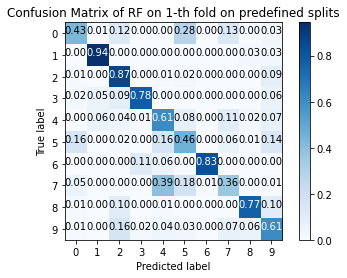

SVM Train accuracy:         0.9965644484031048
SVM Test  accuracy:         0.6529209621993127



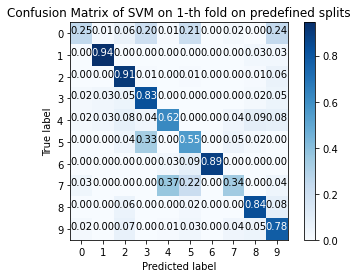

------------------------------------------------
2-th fold:

RF  Train accuracy:         0.9997450280469148
RF  Test  accuracy:         0.6148648648648649



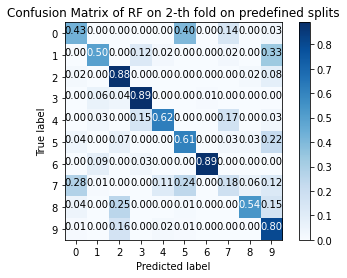

SVM Train accuracy:         0.9961754207037226
SVM Test  accuracy:         0.6948198198198198



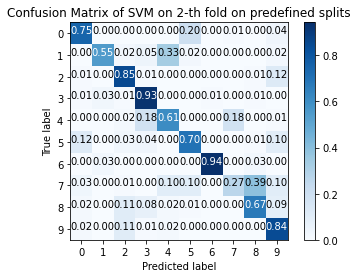

------------------------------------------------
3-th fold:

RF  Train accuracy:         0.9996157294735494
RF  Test  accuracy:         0.6097297297297297



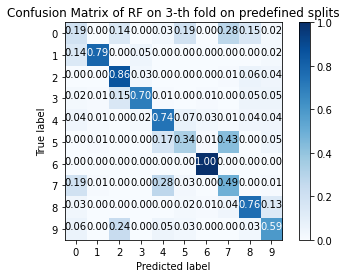

SVM Train accuracy:         0.9956449340335596
SVM Test  accuracy:         0.6345945945945946



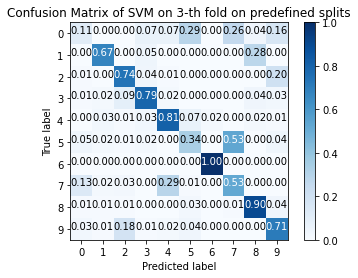

------------------------------------------------
4-th fold:

RF  Train accuracy:         0.9990958408679927
RF  Test  accuracy:         0.6737373737373737



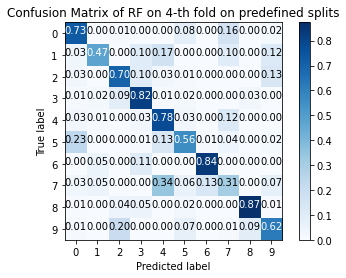

SVM Train accuracy:         0.9954792043399638
SVM Test  accuracy:         0.6656565656565656



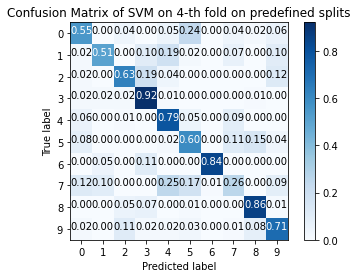

------------------------------------------------
5-th fold:

RF  Train accuracy:         0.9994869163673679
RF  Test  accuracy:         0.7222222222222222



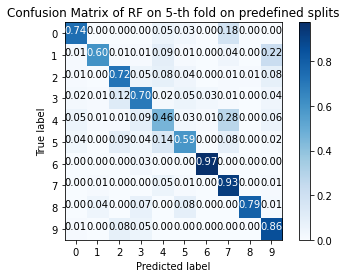

SVM Train accuracy:         0.9949974345818369
SVM Test  accuracy:         0.7649572649572649



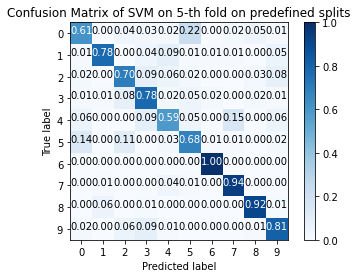

------------------------------------------------
6-th fold:

RF  Train accuracy:         0.9997471235301555
RF  Test  accuracy:         0.6852976913730255



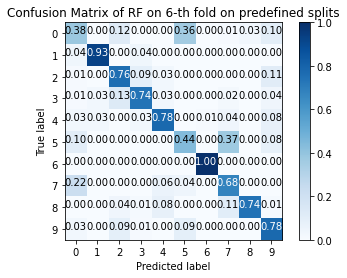

SVM Train accuracy:         0.9951953470729549
SVM Test  accuracy:         0.6950182260024301



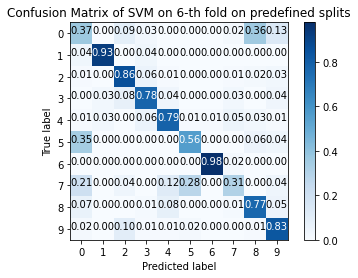

------------------------------------------------
7-th fold:

RF  Train accuracy:         0.9994932860400304
RF  Test  accuracy:         0.6957040572792362



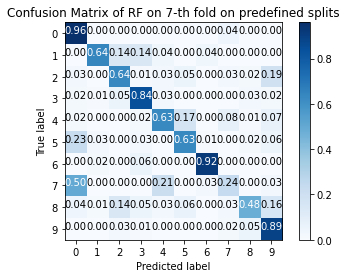

SVM Train accuracy:         0.9963263237902205
SVM Test  accuracy:         0.7505966587112172



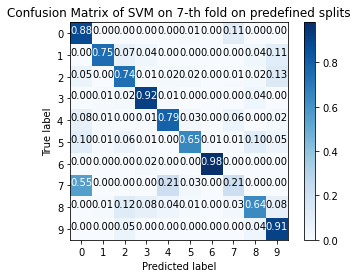

------------------------------------------------
8-th fold:

RF  Train accuracy:         0.9996214988644966
RF  Test  accuracy:         0.6290322580645161



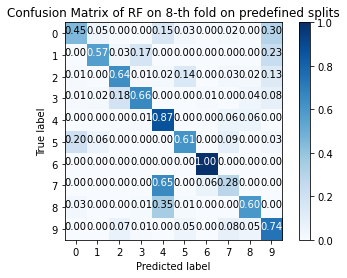

SVM Train accuracy:         0.9952056522836236
SVM Test  accuracy:         0.7344913151364765



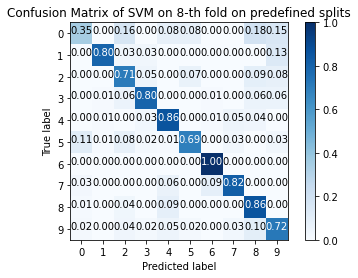

------------------------------------------------
9-th fold:

RF  Train accuracy:         0.9993683678625569
RF  Test  accuracy:         0.6813725490196079



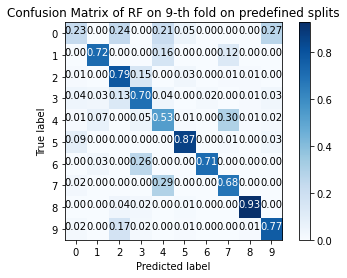

SVM Train accuracy:         0.9963365336028297
SVM Test  accuracy:         0.7193627450980392



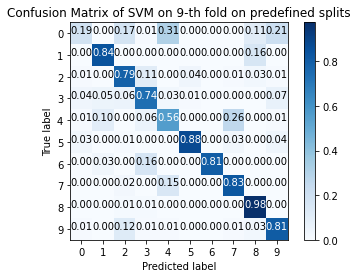

------------------------------------------------
10-th fold:

RF  Train accuracy:         0.9997466751108296
RF  Test  accuracy:         0.7264038231780168



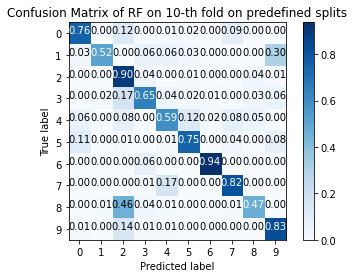

SVM Train accuracy:         0.9948068397720076
SVM Test  accuracy:         0.8004778972520908



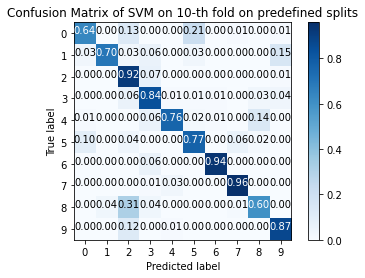

------------------------------------------------




RF  Avg training accuracy :   0.9996
RF  Avg test accuracy     :   0.6664


SVM Avg training accuracy :   0.9957
SVM Avg test accuracy     :   0.7113


In [ ]:
rf_scores, svm_scores = [], []

for k in np.unique(dataset["fold"]):

    X_train = dataset[dataset.fold != k].drop(["signal", "fold", "label"], axis=1)
    X_test = dataset[dataset.fold == k].drop(["signal", "fold", "label"], axis=1)

    Y_train = dataset[dataset.fold != k]["label"]
    Y_test = dataset[dataset.fold == k]["label"]

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    rf = RandomForestClassifier(n_estimators=1000, max_features="auto", max_depth=15, bootstrap=True, criterion="gini", class_weight="balanced", random_state=seed).fit(X_train, Y_train)
    svm = SVC(C=7, kernel="rbf", gamma="scale", class_weight="balanced", break_ties=True, random_state=seed).fit(X_train, Y_train)

    rf_train_scores = rf.score(X_train, Y_train)
    rf_test_scores = rf.score(X_test, Y_test)
    rf_scores.append((rf_train_scores, rf_test_scores))
    rf_cm = confusion_matrix(Y_test, rf.predict(X_test))

    svm_train_scores = svm.score(X_train, Y_train)
    svm_test_scores = svm.score(X_test, Y_test)
    svm_scores.append((svm_train_scores, svm_test_scores))
    svm_cm = confusion_matrix(Y_test, svm.predict(X_test))

    print(f"{k}-th fold:\n")

    print(f"RF  Train accuracy:         {rf_train_scores}")
    print(f"RF  Test  accuracy:         {rf_test_scores}\n")

    plot_confusion_matrix(rf_cm, np.unique(Y_test), title="Confusion Matrix of RF on "+str(k)+"-th fold on predefined splits", path="cm_rf_"+str(k)+"_predefined")

    print(f"SVM Train accuracy:         {svm_train_scores}")
    print(f"SVM Test  accuracy:         {svm_test_scores}\n")

    plot_confusion_matrix(svm_cm, np.unique(Y_test), title="Confusion Matrix of SVM on "+str(k)+"-th fold on predefined splits", path="cm_sv_"+str(k)+"_predefined")

    print("------------------------------------------------")

print("\n\n\n")
print(f"RF  Avg training accuracy :   {round(np.mean([s[0] for s in rf_scores]), 4)}")
print(f"RF  Avg test accuracy     :   {round(np.mean([s[1] for s in rf_scores]), 4)}")
print("\n")
print(f"SVM Avg training accuracy :   {round(np.mean([s[0] for s in svm_scores]), 4)}")
print(f"SVM Avg test accuracy     :   {round(np.mean([s[1] for s in svm_scores]), 4)}")

Learning on the predefined split proved to be definitely harder. Despite the poor scores, we can say that it is indeed possible to face the problem of urban sound classification computing statistics on a set of chosen features. In the same repository there is another notebook in which we face the same problem with CNNs trained on the melspectrogram images of the same audio files.